<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%204/Laboratorio_IV_Soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020




## Objetivos

*   Analizar conjutos de datos no estructurados
*   Aplicar diferentes técnicas de pre-procesamiento de textos.
*   Identificar el mejor modelo para un problema desbalanceado.



## Primer Problema
<p style="text-align: justify;"> El departamento de TI ha desarrollado un servidor de correo para brindar a todos los empleados una cuenta propia donde puedan manejar la información de la empresa. Sin embargo, debido al mal manejo de la cuenta y la falta de capacitación, los directivos se han dado cuenta que a los servidores están llegando varios mensajes <i>Spam</i> que pueden comprometer la seguridad de la información. Para eso, les han pedido construir un sistema el cual permita clasificar y descartar un mensaje <i>Spam</i> antes que llegue a los servidores. <br> Debido a que es un problema reciente y los directivos quieren actuar rápido le han brindado el siguiente archivo con los datos que lograron etiquetar, y les sugieren que utilicen los clasificadores de <i>Näive Bayes</i> y <i>Ensemblers</i>, ya que han escuchado que son muy buenos.</p>


### 1. Importando las librerias requeridas para el desarrollo del laboratorio


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions
import nltk
nltk.download()

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=8dbcafb4f73fa16418ab6f4d0ec9683e5d9e5ae5437b235de3d940b9805b1adb
  Stored in directory: /tmp/pip-ephem-wheel-cache-cd81oam7/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling
NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
import pandas as pd
import numpy as np
import os
import os.path as osp
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve


import matplotlib.pyplot as plt


### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

In [ ]:
!git clone https://github.com/jcestevezc/Machine-Learning-Techniques.git

fatal: destination path 'Machine-Learning-Techniques' already exists and is not an empty directory.


In [ ]:
datos = pd.DataFrame(columns=['Categoria','Texto'])

path = osp.join('Machine-Learning-Techniques','Laboratorio 4','Punto 2','Noticias BBC')
categorias = os.listdir(path)
for cat in categorias:
    if cat.startswith('.'): continue
    articulos = os.listdir(osp.join(path,cat))
    for x in articulos:
        texto = open(osp.join(path,cat,x),'r',encoding='unicode_escape').read()
        
        datos = datos.append({'Categoria':cat,'Texto':texto},ignore_index=True)

print(datos.shape)

display(datos.head())

(2225, 2)


,Categoria,Texto
0,sport,Jol joy at 'professional' Cup win\n\nTottenham...
1,sport,Tindall wants second opinion\n\nEngland centre...
2,sport,Robben and Cole earn Chelsea win\n\nCheslea sa...
3,sport,Isinbayeva claims new world best\n\nPole vault...
4,sport,Call for Kenteris to be cleared\n\nKostas Kent...


#### Entendimiento de los Datos

Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos.

In [ ]:
datos['Conteo'] = [len(x) for x in datos['Texto']]
datos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in datos['Texto']]
datos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in datos['Texto']]
datos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in datos['Texto']]

ProfileReport(datos)

### 3. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

Para mayor información, pueden consultar el [siguiente artículo](https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767
).

#### **3.1 Eliminación del Ruido**
La eliminación del ruido se utiliza para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula.

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [ ]:
datos['words'] = datos['Texto'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [ ]:
datos['words'] = datos['words'].apply(word_tokenize)
datos['words'] = datos['words'].apply(preproccesing) #Aplica la eliminación del ruido
datos.head()

,Categoria,Texto,Conteo,Moda,Max,Min,words
0,sport,Jol joy at 'professional' Cup win\n\nTottenham...,1733,the,14,1,"[jol, joy, professional, cup, win, tottenham, ..."
1,sport,Tindall wants second opinion\n\nEngland centre...,1108,to,21,1,"[tindall, wants, second, opinion, england, cen..."
2,sport,Robben and Cole earn Chelsea win\n\nCheslea sa...,2510,a,24,1,"[robben, cole, earn, chelsea, win, cheslea, sa..."
3,sport,Isinbayeva claims new world best\n\nPole vault...,811,the,13,1,"[isinbayeva, claims, new, world, best, pole, v..."
4,sport,Call for Kenteris to be cleared\n\nKostas Kent...,1549,the,17,1,"[call, kenteris, cleared, kostas, kenteris, la..."


#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

datos['words'] = datos['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
datos.head()

,Categoria,Texto,Conteo,Moda,Max,Min,words
0,sport,Jol joy at 'professional' Cup win\n\nTottenham...,1733,the,14,1,"[jol, joy, profess, cup, win, tottenham, man, ..."
1,sport,Tindall wants second opinion\n\nEngland centre...,1108,to,21,1,"[tindal, want, second, opin, england, cent, mi..."
2,sport,Robben and Cole earn Chelsea win\n\nCheslea sa...,2510,a,24,1,"[rob, col, earn, chelse, win, chesle, salv, wi..."
3,sport,Isinbayeva claims new world best\n\nPole vault...,811,the,13,1,"[isinbayev, claim, new, world, best, pol, vaul..."
4,sport,Call for Kenteris to be cleared\n\nKostas Kent...,1549,the,17,1,"[cal, kent, clear, kosta, kent, lawy, cal, dop..."


##### **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [ ]:
datos['words'] = datos['words'].apply(lambda x: ' '.join(map(str, x)))
datos

,Categoria,Texto,Conteo,Moda,Max,Min,words
0,sport,Jol joy at 'professional' Cup win\n\nTottenham...,1733,the,14,1,jol joy profess cup win tottenham man martin j...
1,sport,Tindall wants second opinion\n\nEngland centre...,1108,to,21,1,tindal want second opin england cent mik tinda...
2,sport,Robben and Cole earn Chelsea win\n\nCheslea sa...,2510,a,24,1,rob col earn chelse win chesle salv win battl ...
3,sport,Isinbayeva claims new world best\n\nPole vault...,811,the,13,1,isinbayev claim new world best pol vault yelen...
4,sport,Call for Kenteris to be cleared\n\nKostas Kent...,1549,the,17,1,cal kent clear kosta kent lawy cal dop charg g...
...,...,...,...,...,...,...,...
2220,business,Steady job growth continues in US\n\nThe US cr...,2196,the,21,1,steady job grow continu us us cre few job expe...
2221,business,Worldcom boss 'left books alone'\n\nFormer Wor...,1845,the,16,1,worldcom boss left book alon form worldcom bos...
2222,business,Glazer makes new Man Utd approach\n\nMalcolm G...,2259,the,17,1,glaz mak new man utd approach malcolm glaz mad...
2223,business,The 'ticking budget' facing the US\n\nThe budg...,4944,the,26,1,tick budget fac us budget propos laid admin us...


In [ ]:
X, y = datos['words'],datos['Categoria']
y

0          sport
1          sport
2          sport
3          sport
4          sport
          ...   
2220    business
2221    business
2222    business
2223    business
2224    business
Name: Categoria, Length: 2225, dtype: object

Y se realiza la selección de los conjuntos de entrenamiento y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=20)
X_train

1349    amnesty chief lam war fail lack publ out war t...
1682    blair stresses prosp goal tony blair say party...
834     fock keep us box off lead film comedy meet foc...
1011    inv turn innov unlik fut technolog inv going k...
1772    tat lyl boss bag top award tat lyl chief execu...
                              ...                        
552     alic key op us sup bowl r b star alic key op f...
1607    glant tory heal check uk opposit conserv unvei...
1814    hous pric drop sal slow hous pric fel novemb p...
1428    blair back preelect budget tony blair back cha...
271     martinez see vinc challeng vet spaniard conchi...
Name: words, Length: 1780, dtype: object

### 4. Modelamiento

#### **Näive Bayes**

El algoritmo de Näive Bayes es un clasificador estadístico basado en el teorema de Bayes. 

**Dado:**

> $A: $ Eventos mutuamente exclusivos y exhaustivos (estados). <br>
$E: $ Evento observado.

El teorema establece:

$P(A_i|E) = \frac{P(E|A_i)P(A_i)}{P(E)}$

Basado en los datos que se le proporciona, estima la probabilidad que una instancia pertenezca a cada una de las clases. Y con la mayor probabilidad encontrada, asigna el valor de la clase. 

Existen tres tipos de calsificadores Bayes:

*   Bayes Ingenuo.
*   Bayes ingenuo Bernoulli (para atributos binarios).
*   Bayes ingenuo multinomial (para características discretas).

Para este caso, se utilizará el Bayes ingenuo Bernoulli.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

estimators = [('transform', TfidfVectorizer()), ('clf', BernoulliNB())]
pipe = Pipeline(estimators)

NB = pipe.fit(X_train,y_train)
NB

Pipeline(memory=None,
         steps=[('transform',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

### **5. Predicción**

#### Näive Bayes

In [ ]:
y_pred_NB = NB.predict(X_test)
y_pred_NB

array(['sport', 'politics', 'sport', 'entertainment', 'politics',
       'politics', 'business', 'sport', 'politics', 'business', 'tech',
       'sport', 'business', 'business', 'entertainment', 'entertainment',
       'entertainment', 'entertainment', 'sport', 'politics', 'business',
       'business', 'politics', 'tech', 'sport', 'entertainment',
       'politics', 'politics', 'entertainment', 'business', 'sport',
       'sport', 'tech', 'business', 'sport', 'tech', 'tech', 'business',
       'politics', 'entertainment', 'entertainment', 'business', 'tech',
       'sport', 'politics', 'sport', 'sport', 'business', 'business',
       'business', 'sport', 'tech', 'entertainment', 'business',
       'politics', 'politics', 'business', 'entertainment', 'sport',
       'politics', 'entertainment', 'politics', 'business', 'tech',
       'politics', 'politics', 'tech', 'entertainment', 'entertainment',
       'sport', 'sport', 'entertainment', 'entertainment', 'tech',
       'sport', 'busin

### **6. Validación**

Para comparar los dos modelos, se realiza la evaluación en el conjunto de test y se construye la matriz de confusión.

In [ ]:
report_NB = classification_report(y_test, y_pred_NB,target_names=y_test.unique())


print("Test Report for Näive Bayes\n", report_NB)
print("Confusion Matrix for Näive Bayes\n", confusion_matrix(y_test, y_pred_NB))

Test Report for Näive Bayes
                precision    recall  f1-score   support

        sport       0.93      0.99      0.96       106
     politics       0.98      0.96      0.97        82
entertainment       1.00      0.97      0.99        79
     business       1.00      0.99      1.00       110
         tech       0.95      0.91      0.93        68

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445

Confusion Matrix for Näive Bayes
 [[105   0   0   0   1]
 [  1  79   0   0   2]
 [  2   0  77   0   0]
 [  1   0   0 109   0]
 [  4   2   0   0  62]]


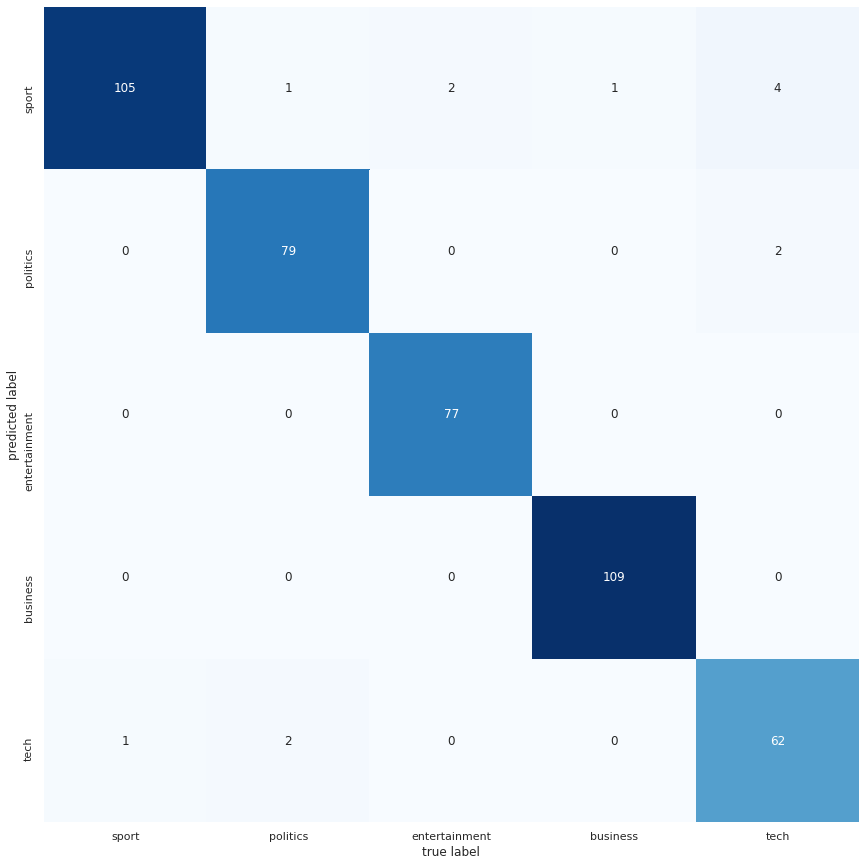

In [ ]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,15))
mat = confusion_matrix(y_test, y_pred_NB)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y_test.unique(),
            yticklabels=y_test.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');